# Exercise 4: Ridge Regression on the Franke function  with resampling (score 20 points)

Write your own code for the Ridge method, either using matrix
inversion or the singular value decomposition as done in the previous
exercise. Perform the same bootstrap analysis as in the
Exercise 2  (for the same polynomials) and the cross-validation  in exercise 3 but now for different values of $\lambda$. Compare and
analyze your results with those obtained in exercises 1-3. Study the
dependence on $\lambda$.

Study also the bias-variance trade-off as function of various values of
the parameter $\lambda$. For the bias-variance trade-off, use the **bootstrap** resampling method. Comment your results. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import  train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.preprocessing import StandardScaler



def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def FrankeFunctionWithNoise(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    noise = np.random.normal(0, 0.1, len(x)*len(x))
    noise = noise.reshape(len(x),len(x))
    return term1 + term2 + term3 + term4 + noise


def create_X(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
    return X

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)


Polynomial degree: 3
Log10(Lambda): -3.0
---------Bootstrap---------
Error: 0.020938437049735074
Bias^2: 0.020172989460165405
Var: 0.0007654475895696694
0.020938437049735074 >= 0.020172989460165405 + 0.0007654475895696694 = 0.020938437049735074
---------Cross Validation---------
Error_sklearn: 0.022499619601489166



Polynomial degree: 3
Log10(Lambda): -2.919191919191919
---------Bootstrap---------
Error: 0.020788971673241143
Bias^2: 0.020167545246831047
Var: 0.0006214264264100963
0.020788971673241143 >= 0.020167545246831047 + 0.0006214264264100963 = 0.020788971673241143
---------Cross Validation---------
Error_sklearn: 0.02249959610894246



Polynomial degree: 3
Log10(Lambda): -2.8383838383838382
---------Bootstrap---------
Error: 0.020941020445560576
Bias^2: 0.020327307014356068
Var: 0.0006137134312045054
0.020941020445560576 >= 0.020327307014356068 + 0.0006137134312045054 = 0.020941020445560572
---------Cross Validation---------
Error_sklearn: 0.02249956782002632



Polynomial degre

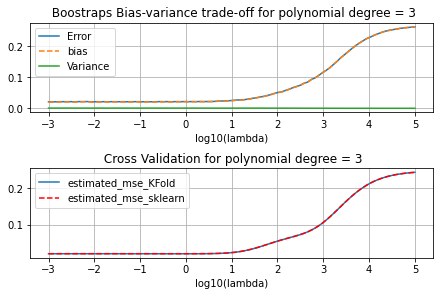

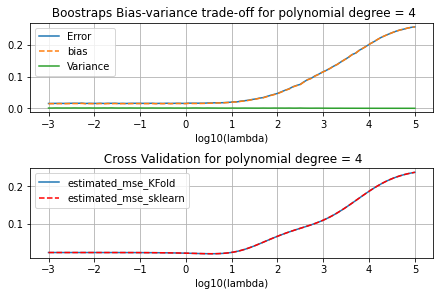

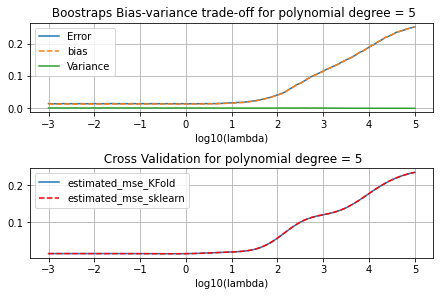

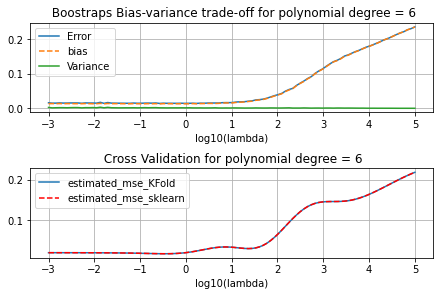

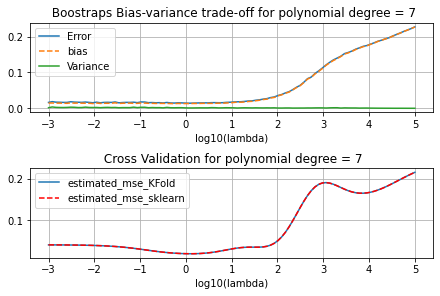

In [3]:
################# Parameters #################

n = 20  #number of data
polynomial = 10 #polynomial degree
list_degree = [3, 4, 5, 6, 7]
k = 10 #number of splits
n_bootstraps = 20
nlambdas = 100
lambdas = np.logspace(-3, 5, nlambdas)

#############################################

#Set up the data
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
x, y = np.meshgrid(x, y)
z = FrankeFunctionWithNoise(x, y)
z = z.ravel()


x_y = np.empty((len(x)*len(x), 2))
x_y[:, 0] = x.ravel()
x_y[:, 1] = y.ravel()


#scale our data
scaler = StandardScaler()
scaler.fit(x_y)
x_y = scaler.transform(x_y)

x_y_train, x_y_test, z_train, z_test = train_test_split(x_y, z.ravel(), test_size=0.2)

#set up our kfolds 
kfold = KFold(n_splits=k)

min_error = []
min_lambdas = []


#For each polynomial degree
for degree in list_degree:
    
    #set up the score for each of kfolds
    scores_KFold = np.zeros((nlambdas, k))
    estimated_mse_sklearn = np.zeros(nlambdas)


    error = np.zeros(lambdas.shape[0])
    bias = np.zeros(lambdas.shape[0])
    variance = np.zeros(lambdas.shape[0])


    j = 0
    
    #set up our polynomial features
    poly = PolynomialFeatures(degree=degree)
    
    
    for l in lambdas:
        
        #for each lambda set up our ridge model
        ridge = Ridge(alpha=l, fit_intercept=False)
        #set up our prediction
        pred_test = np.empty((z_test.shape[0], n_bootstraps))
        pred_train = np.empty((z_train.shape[0], n_bootstraps))

        
        
        for i in range(n_bootstraps):
            #for each boostraps resemple our data and compute ou prediction
            x_y_, z_ = resample(x_y_train, z_train)
            X_train = create_X(x_y_[:, 0], x_y_[:, 1], degree)
            X_test = create_X(x_y_test[:, 0], x_y_test[:, 1], degree)
            RidgeBeta = np.linalg.pinv(X_train.T.dot(X_train) + l * np.eye(X_train.T.dot(X_train).shape[0])).dot(X_train.T).dot(z_)
            pred_test[:, i] = X_test @ RidgeBeta
            pred_train[:, i] = X_train @ RidgeBeta


        z_pred_kfold  = np.empty((int(z.shape[0] / k), k))
        h = 0

        
        for train_index, test_index in kfold.split(x_y):
            #Set up our train and test data
            x_train_kfold, x_test_kfold  = x_y[train_index], x_y[test_index]
            z_train_kfold, z_test_kfold = z[train_index], z[test_index]
            #set up our prediction for train and test data
            X_train = poly.fit_transform(x_train_kfold)
            ridge.fit(X_train, z_train_kfold)
            Xtest = poly.fit_transform(x_test_kfold)
            zpred = ridge.predict(Xtest)
            scores_KFold[j, h] = np.sum((zpred - z_test_kfold) ** 2) / np.size(zpred)
            z_pred_kfold[:, h] = zpred
            h += 1

        
        
        #Compute our score from Cross-validation
        X = poly.fit_transform(x_y)
        estimated_mse_folds = cross_val_score(ridge, X, z, scoring='neg_mean_squared_error',cv=kfold)
        estimated_mse_sklearn[j] = np.mean(-estimated_mse_folds)

        #set up our kfolds and the score for each of them 
        error[j] = np.mean(np.mean((z_test.reshape(z_test.shape[0], 1) - pred_test) ** 2, axis=1, keepdims=True))
        bias[j] = np.mean((z_test.reshape(z_test.shape[0], 1) - np.mean(pred_test, axis=1, keepdims=True)) ** 2)
        variance[j] = np.mean(np.var(pred_test, axis=1, keepdims=True))


        print('Polynomial degree:', degree)
        print('Log10(Lambda):',np.log10(l) )
        print("---------Bootstrap---------")
        print('Error:', error[j])
        print('Bias^2:', bias[j])
        print('Var:', variance[j])
        print('{} >= {} + {} = {}'.format(error[j], bias[j], variance[j], bias[j] + variance[j]))
        print("---------Cross Validation---------")
        print('Error_sklearn:', estimated_mse_sklearn[j])
        print("\n\n")

        j +=1

   

    estimated_mse_KFold = np.mean(scores_KFold, axis=1)
    
    min_error.append(min(estimated_mse_KFold))
    min_lambdas.append(lambdas[np.where(estimated_mse_KFold == np.min(estimated_mse_KFold))])
    
    
    fig, axs = plt.subplots(2, 1, constrained_layout=True)
    axs[0].plot(np.log10(lambdas), error, label='Error')
    axs[0].plot(np.log10(lambdas), bias, '--', label='bias')
    axs[0].plot(np.log10(lambdas), variance, label='Variance')
    axs[0].set_title(" Boostraps Bias-variance trade-off for polynomial degree = " + str(degree))
    axs[0].set_xlabel("log10(lambda)")
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(np.log10(lambdas), estimated_mse_KFold, label='estimated_mse_KFold')
    axs[1].plot(np.log10(lambdas), estimated_mse_sklearn,'r--',  label='estimated_mse_sklearn')
    axs[1].set_title(" Cross Validation for polynomial degree = " + str(degree))
    axs[1].set_xlabel("log10(lambda)")
    axs[1].legend()
    axs[1].grid()

plt.show()

In [5]:
for i in range(len(list_degree)):
    print("for polynomial degree = ", list_degree[i])
    print("the minimum of MSE is : ", min_error[i])
    print("for lambda = ", min_lambdas[i])
    print("\n\n")

for polynomial degree =  3
the minimum of MSE is :  0.022451128328531078
for lambda =  [0.81113083]



for polynomial degree =  4
the minimum of MSE is :  0.019850559012334512
for lambda =  [3.59381366]



for polynomial degree =  5
the minimum of MSE is :  0.01584935040552054
for lambda =  [0.46415888]



for polynomial degree =  6
the minimum of MSE is :  0.016955088329875745
for lambda =  [0.31992671]



for polynomial degree =  7
the minimum of MSE is :  0.02049161540837956
for lambda =  [1.17681195]



